In [54]:
!pip install imutils
!pip install keras-tuner

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imutils
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import kerastuner as kt
from kerastuner import HyperModel

## EDA and Pre-Processing

#### Exploratory Data Analysis

In this section, we perform exploratory data analysis (EDA) to understand the characteristics of our dataset before training the model. The steps are as follows:

#### Dataset Distribution
We begin by defining the directories for the training and testing datasets, and listing the categories of interest: glioma, meningioma, no tumor, and pituitary. We then use a function to count the number of images in each category within these directories. The counts are computed for both the training and testing datasets to evaluate the distribution of images across categories. This helps us verify that the dataset is balanced.

#### Distribution Visualization
To visualize the distribution of images, we generate bar plots showing the number of images in each category for both the training and testing sets. These plots are useful for identifying any imbalances in the dataset and ensuring that no category is disproportionately represented.

#### Sample Images Display
We define a function to display sample images from each category. This function randomly selects a specified number of images from each category and arranges them in a grid. By examining these sample images from both the training and testing sets, we can visually inspect the data to ensure it is correctly categorized and representative of each class.

Through this EDA, we aim to gain insights into the dataset's balance and the nature of the images, which is crucial for training an effective model.


Training set image counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing set image counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


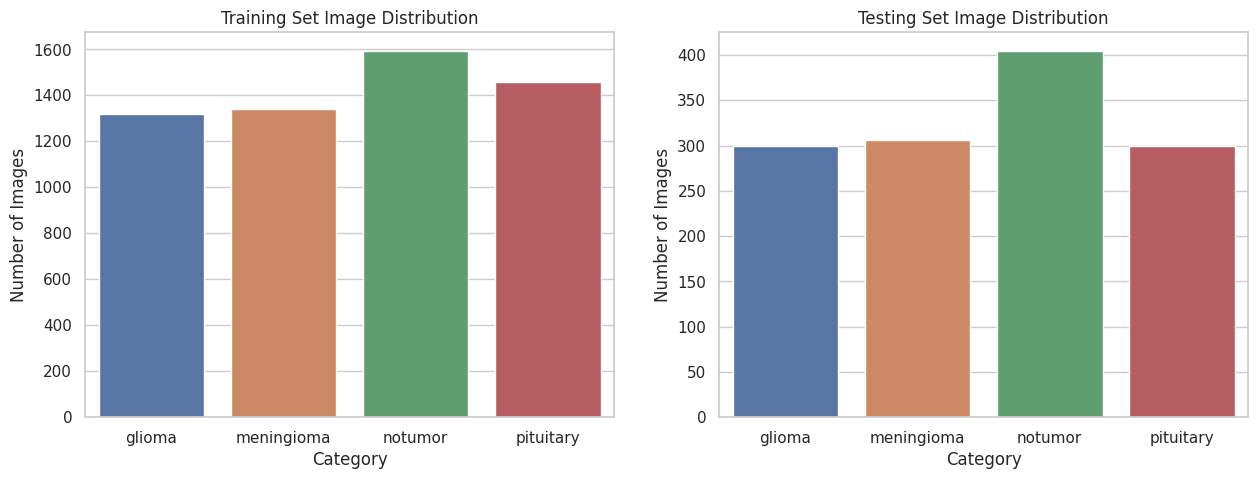

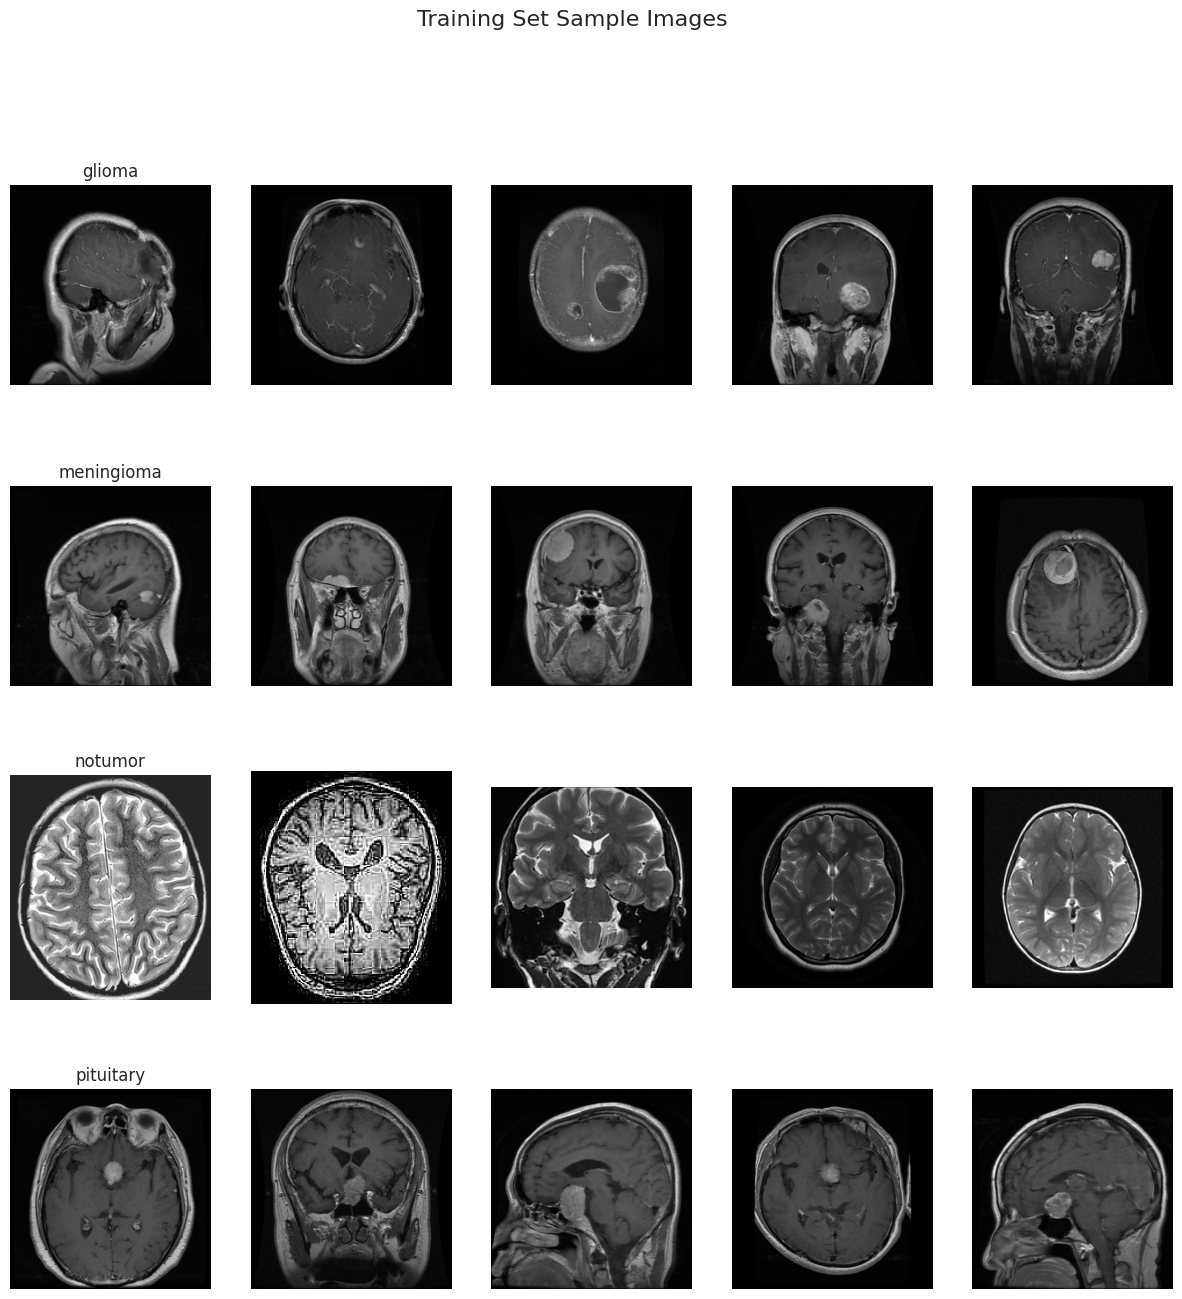

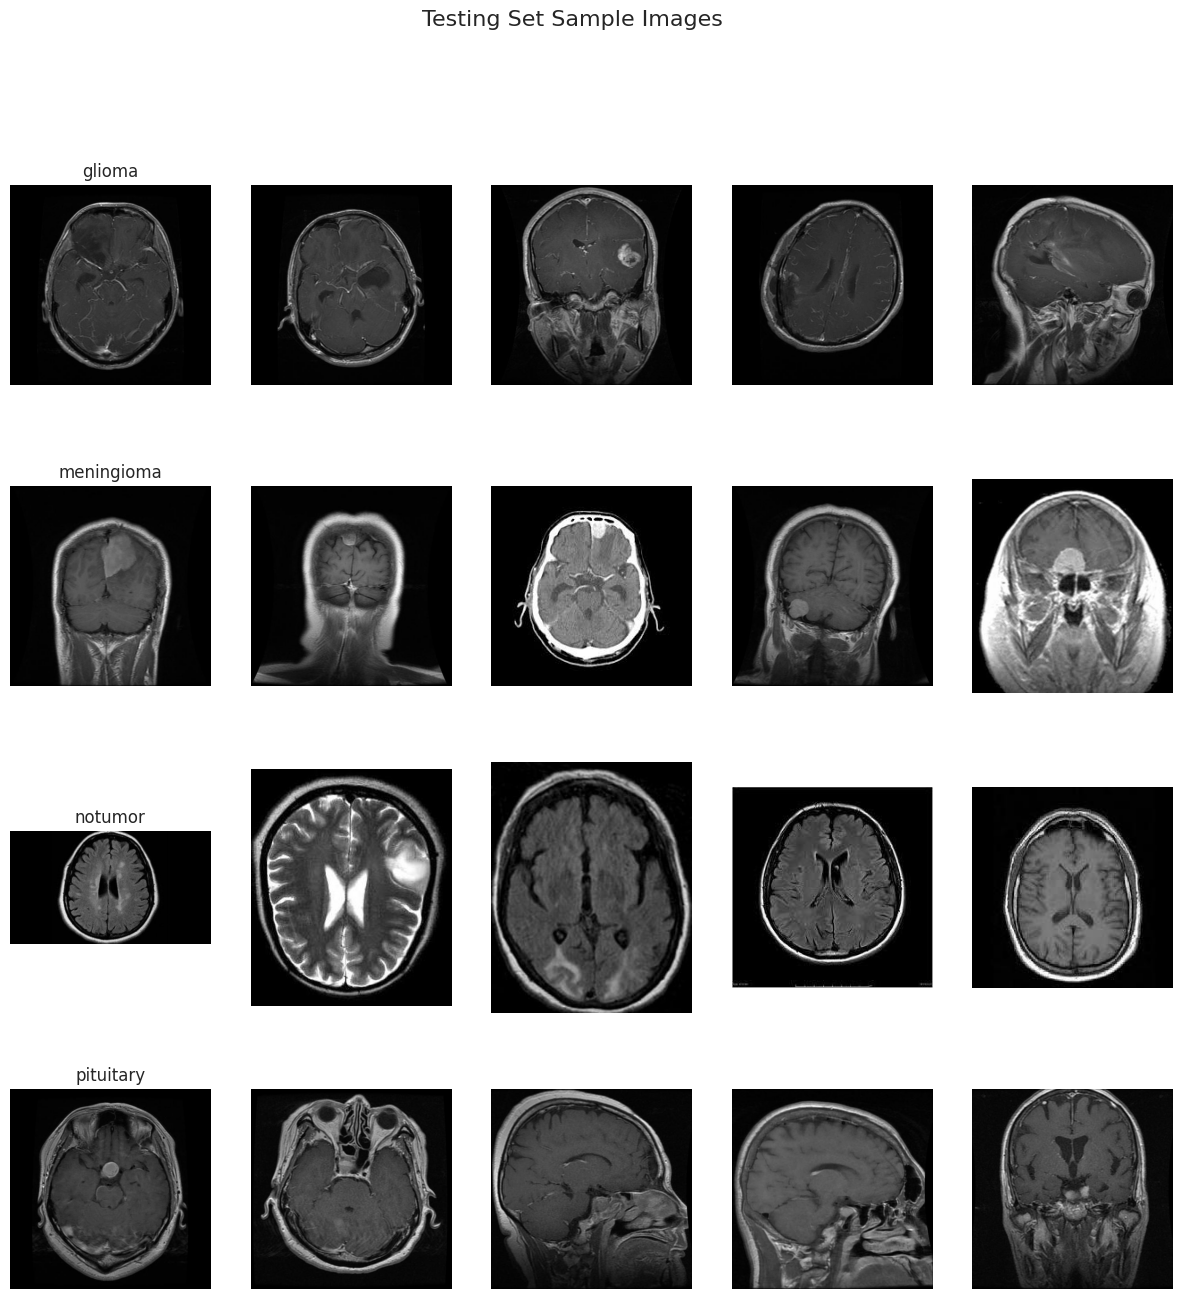

In [56]:
# Define the dataset paths
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Function to count images in each category
def count_images(directory):
    category_counts = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        category_counts[category] = len(os.listdir(category_path))
    return category_counts

# Count images in training and testing sets
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

# Display the counts
print("Training set image counts:", train_counts)
print("Testing set image counts:", test_counts)

# Plot the distribution of images in each category
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0])
ax[0].set_title('Training Set Image Distribution')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Number of Images')

sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[1])
ax[1].set_title('Testing Set Image Distribution')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Number of Images')

plt.show()

# Function to display sample images from each category
def display_sample_images(directory, categories, num_samples=5, title='Sample Images'):
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 15))
    fig.suptitle(title, fontsize=16)
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        sample_images = np.random.choice(os.listdir(category_path), num_samples, replace=False)
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category)
    plt.show()

# Display sample images from training set
display_sample_images(train_dir, categories, title='Training Set Sample Images')

# Display sample images from testing set
display_sample_images(test_dir, categories, title='Testing Set Sample Images')


### Preprocessing Code Explanation

The preprocessing functions below was provided by the dataset in kaggle (https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) This was recommended to be included by the instructions prior to additonal preprocessing steps. The steps provided are designed to ensure that all images in the dataset are of consistent size and format, making them suitable for training a convolutional neural network (CNN). The following is a high level break down of the sequence. 

1. **Cropping Function (`crop_img`)**:
   - **Purpose**: To crop images to remove unwanted borders and focus on the main content.
   - **Method**:
     - Convert the image to grayscale and apply Gaussian blur.
     - Threshold the image to create a binary image, followed by erosion and dilation to remove noise.
     - Find contours and identify the largest one to determine the extreme points (left, right, top, bottom).
     - Crop the image based on these extreme points.

2. **Processing Directory Function (`process_directory`)**:
   - **Purpose**: To process all images in a given directory by cropping and resizing them.
   - **Method**:
     - Iterate over each category and image file in the specified directory.
     - Apply the cropping function to each image.
     - Resize the cropped image to a predefined size (`IMG_SIZE = 256`).
     - Save the processed image to a new directory.

3. **Resizing Images**:
   - **Purpose**: To resize images to the final size required by the CNN (`128x128`).
   - **Method**:
     - Iterate over each category and image file in the preprocessed directory.
     - Resize each image to `128x128` pixels.
     - Convert images to RGB mode if necessary and save them.

4. **Data Preparation**:
   - **Loading and Normalizing**:
     - Load images from the resized directory and convert them to numpy arrays.
     - Normalize pixel values to the range [0, 1].
   - **One-Hot Encoding**:
     - Convert categorical labels into a one-hot encoded format using `LabelBinarizer`.
   - **Data Augmentation**:
     - Apply random horizontal and vertical flips, rotations, and zooms to increase data variability.
   - **TensorFlow Dataset**:
     - Create a TensorFlow dataset from the images and labels.
     - Shuffle and batch the dataset, and apply data augmentation.


In [57]:
def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Threshold the image, then perform a series of erosions and dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    return new_img

def process_directory(input_dir, output_dir, img_size):
    """
    Processes all images in the given directory, cropping and resizing them.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    subdirs = os.listdir(input_dir)
    for subdir in subdirs:
        subdir_path = os.path.join(input_dir, subdir)
        if not os.path.isdir(subdir_path):
            continue
        save_subdir_path = os.path.join(output_dir, subdir)
        if not os.path.exists(save_subdir_path):
            os.makedirs(save_subdir_path)

        image_files = os.listdir(subdir_path)
        for img_file in tqdm(image_files, desc=f"Processing {subdir}"):
            img_path = os.path.join(subdir_path, img_file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (img_size, img_size))
            save_path = os.path.join(save_subdir_path, img_file)
            cv2.imwrite(save_path, new_img)

if __name__ == "__main__":
    training_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
    testing_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"
    cleaned_training_dir = "/kaggle/working/cleaned/Training"
    cleaned_testing_dir = "/kaggle/working/cleaned/Testing"
    IMG_SIZE = 256

    # Process training images
    process_directory(training_dir, cleaned_training_dir, IMG_SIZE)

    # Process testing images
    process_directory(testing_dir, cleaned_testing_dir, IMG_SIZE)


Processing glioma: 100%|██████████| 300/300 [00:01<00:00, 240.66it/s]


In [58]:
# Define the new size
new_size = (128, 128)

# Function to resize images
def resize_images(directory, categories, output_dir, new_size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for category in categories:
        category_path = os.path.join(directory, category)
        output_category_path = os.path.join(output_dir, category)
        
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.resize(new_size, Image.ANTIALIAS)
                
                # Convert image to RGB mode if it's not in an appropriate mode for JPEG
                if img.mode not in ("RGB", "L"):
                    img = img.convert("RGB")
                
                # Modify filename to include "CNN"
                base, ext = os.path.splitext(img_name)
                new_img_name = f"{base}_CNN{ext}"
                
                img.save(os.path.join(output_category_path, new_img_name))
            except Exception as e:
                print(f"Error resizing image {img_name}: {e}")

# Define the output directories in /kaggle/working/
train_resized_dir = '/kaggle/working/brain-tumor-mri-dataset-resized/TrainingCNN'
test_resized_dir = '/kaggle/working/brain-tumor-mri-dataset-resized/TestingCNN'

# Resize the images in the training and testing sets
resize_images(train_dir, categories, train_resized_dir, new_size)
resize_images(test_dir, categories, test_resized_dir, new_size)

print("Resizing complete. Resized images are saved in the new directories in /kaggle/working/")

# Define directories
train_resized_dir = "/kaggle/working/brain-tumor-mri-dataset-resized/TrainingCNN"
test_resized_dir = "/kaggle/working/brain-tumor-mri-dataset-resized/TestingCNN"

# Categories (assuming these are the categories)
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Define the new size and batch size
new_size = (128, 128)  # Ensure this matches the resized images
batch_size = 32

# Function to load images and labels
def load_images_and_labels(directory, categories, new_size):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(directory, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.resize(new_size)
                img = np.array(img)
                if img.shape == (128, 128, 3):  # Ensure image has correct shape
                    images.append(img)
                    labels.append(category)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
    return np.array(images), np.array(labels)

# Load the training images and labels
train_images, train_labels = load_images_and_labels(train_resized_dir, categories, new_size)

# Normalize pixel values
train_images = train_images.astype('float32') / 255.0

# One-hot encode labels
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Apply data augmentation
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

# Print dataset details
print(f"Training dataset: {train_images.shape[0]} images")


/tmp/ipykernel_34/528237819.py:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(new_size, Image.ANTIALIAS)


Resizing complete. Resized images are saved in the new directories in /kaggle/working/
Training dataset: 3240 images


### Model Building

### 1. CNN Architecture Definition

### Model Design

#### Convolutional Layers
- **Purpose:** Convolutional layers of Convolutional Neural Networks (CNNs) are designed to automatically and adaptively learn spatial hierarchies of features from input images.
- **Filter Sizes:** 
  - **32 Filters:** The first convolutional layer uses 32 filters, allowing the model to learn low-level features such as edges and textures.
  - **64 Filters:** The second convolutional layer increases the number of filters to 64, enabling the model to learn more complex features by combining lower-level features detected in the previous layer.
  - **128 Filters:** The third convolutional layer further increases the number of filters to 128, allowing the model to capture high-level features and patterns in the image.
- **Kernel Size:** Each convolutional layer uses a kernel size of (3, 3). This size is small enough to capture local patterns while large enough to cover sufficient spatial area. Small kernels also help in reducing the number of parameters and computation, making the model more efficient.
- **Max Pooling:** Following each convolutional layer, max pooling layers are used to:
  - **Reduce Spatial Dimensions:** This decreases the spatial size of the representation, which reduces the number of parameters and computation in the network.
  - **Highlight Features:** Max pooling retains the most important features from the convolutional layers, contributing to the network’s ability to focus on the most salient features.

#### Flatten Layer
- **Purpose:** The flatten layer converts the 2D feature maps produced by the convolutional and pooling layers into a 1D vector. This transformation is necessary to pass the data into fully connected (dense) layers, which require a 1D input.

#### Dense Layers
- **Fully Connected Dense Layer:**
  - **128 Units:** The first dense layer has 128 units with ReLU (Rectified Linear Unit) activation. This layer helps the model learn complex representations by combining the features learned by the convolutional layers. The choice of 128 units is a common practice that balances model complexity and computational efficiency.
  - **ReLU Activation:** ReLU activation introduces non-linearity into the model, which allows it to learn more complex patterns and relationships in the data.
- **Dropout Layer:**
  - **Dropout Rate of 0.5:** Dropout is used to prevent overfitting by randomly setting a fraction (50% in this case) of the input units to zero during training. This forces the network to learn redundant representations and ensures that the model generalizes better to unseen data.
  
#### Output Layer
- **Purpose:** The output layer produces the final class probabilities based on the learned features.
- **Dense Layer:** 
  - **Units Equal to Number of Classes:** The number of units in the output layer corresponds to the number of classes in the classification task. Each unit represents a class, and the model outputs a probability distribution over these classes.
  - **Softmax Activation:** Softmax activation function converts the raw output scores into probabilities that sum to 1. This provides a normalized probability distribution across the classes, which is suitable for multi-class classification problems.

**Compilation:**
- **Optimizer:** Adam
- **Loss Function:** Categorical crossentropy
- **Metrics:** Accuracy

### 2. Data Preparation

**Dataset Splitting:**
- The dataset was split into training and validation sets with a 20% validation split.

### 3. Model Training

**Callbacks:**
- **Early Stopping:** Training halted when no improvement in validation loss was observed for 3 consecutive epochs.
- **Learning Rate Reduction:** Adjusted the learning rate when validation loss plateaued after 2 consecutive epochs.

**Training:**
- The model was trained for 10 epochs using the training and validation datasets. The training history, including accuracy and loss metrics, was recorded for analysis.

### 4. Hyperparameter Tuning

**Hypermodel Definition:**
- A hypermodel class was defined using Keras Tuner, including hyperparameters for:
  - Number of convolutional layers
  - Number of filters
  - Kernel size
  - Dropout rates
  - Learning rate

**Tuning Process:**
- A Random Search tuner was used to explore different hyperparameter combinations. The best hyperparameters were selected based on validation accuracy.

**Best Model Evaluation:**
- The best model obtained from hyperparameter tuning was evaluated on the validation dataset, showing high validation accuracy.

### 5. Model Evaluation on Test Data

**Evaluation:**
- The model was evaluated on the test dataset, providing metrics such as loss and accuracy.


In [59]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN architecture
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Set input shape and number of classes
input_shape = (128, 128, 3) #using the known values from the resizing
num_classes = len(categories)

# Build the model
model = build_cnn(input_shape, num_classes)

# Print the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
# Split the dataset into training and validation sets
validation_split = 0.2
dataset_size = len(train_images)
val_size = int(dataset_size * validation_split)
train_size = dataset_size - val_size

train_dataset = tf.data.Dataset.from_tensor_slices((train_images[:train_size], train_labels[:train_size]))
val_dataset = tf.data.Dataset.from_tensor_slices((train_images[train_size:], train_labels[train_size:]))

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model
epochs = 10
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

# Print training history
print(history.history)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6773 - loss: 0.8812 - val_accuracy: 0.6590 - val_loss: 1.0391 - learning_rate: 0.0010
Epoch 2/10
11/81 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7156 - loss: 0.7196

W0000 00:00:1721363691.430545     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8059 - loss: 0.5379 - val_accuracy: 0.6451 - val_loss: 1.0463 - learning_rate: 0.0010
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8492 - loss: 0.4482 - val_accuracy: 0.8704 - val_loss: 0.5706 - learning_rate: 0.0010
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8824 - loss: 0.3404 - val_accuracy: 0.8519 - val_loss: 0.7625 - learning_rate: 0.0010
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9060 - loss: 0.2760 - val_accuracy: 0.8225 - val_loss: 0.7228 - learning_rate: 0.0010
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9021 - loss: 0.2988 - val_accuracy: 0.8596 - val_loss: 0.5980 - learning_rate: 2.0000e-04
{'accuracy': [0.7615740895271301, 0.8402777910232544, 0.8819444179534912, 0.8966049551963806, 0.9236111044883728, 0.9278549551963806], 'loss': [0.6904800534248352, 0.4551205635070801, 0.3480638265609741, 0.3005840480327606, 0.23021718859672546, 0.21519

In [62]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(layers.Input(shape=self.input_shape))
        
        for i in range(hp.Int('num_conv_layers', 1, 4)):
            model.add(layers.Conv2D(
                filters=hp.Int('filters_' + str(i), 32, 128, step=32),
                kernel_size=hp.Choice('kernel_size_' + str(i), [3, 5]),
                activation='relu',
                padding='same'
            ))
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))
            if hp.Float('dropout_' + str(i), 0, 0.5, step=0.1) > 0:
                model.add(layers.Dropout(hp.Float('dropout_' + str(i), 0, 0.5, step=0.1)))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(self.num_classes, activation='softmax'))
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


In [63]:
# Define the hypermodel
hypermodel = CNNHyperModel(input_shape=(128, 128, 3), num_classes=len(categories))

# Instantiate the tuner
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

# Search for the best hyperparameters
tuner.search(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(best_hyperparameters.values)

# Build the best model
best_model = tuner.get_best_models()[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(val_dataset)
print(f"Validation accuracy: {accuracy}")


Reloading Tuner from my_dir/helloworld/tuner0.json
{'num_conv_layers': 3, 'filters_0': 96, 'kernel_size_0': 3, 'dropout_0': 0.4, 'learning_rate': 0.002162662438641237, 'filters_1': 64, 'kernel_size_1': 3, 'dropout_1': 0.1, 'filters_2': 128, 'kernel_size_2': 3, 'dropout_2': 0.1, 'filters_3': 32, 'kernel_size_3': 5, 'dropout_3': 0.0}


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9810 - loss: 1.4782 
Validation accuracy: 0.979938268661499


In [64]:
# Define paths and parameters
# test_dir = '/kaggle/working/brain-tumor-mri-dataset-resized/Testing'
new_size = (128, 128)  # Size used for resizing

# Define categories and load test images
# categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
test_images, test_labels = load_images_and_labels(test_dir, categories, new_size)

# Normalize pixel values
test_images = test_images.astype('float32') / 255.0

# One-hot encode labels
label_binarizer = LabelBinarizer()
test_labels = label_binarizer.fit_transform(test_labels)

# Create a TensorFlow dataset for the test set
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print test results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6439 - loss: 0.9652
Test Loss: 0.6145514249801636
Test Accuracy: 0.7840579748153687


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


<Figure size 1000x800 with 0 Axes>

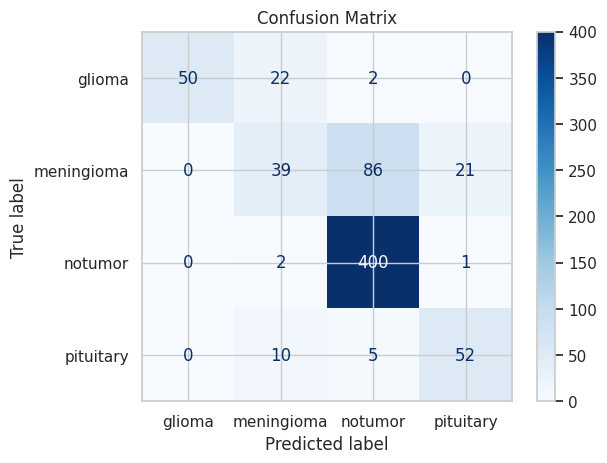

In [65]:
# Predict labels for the test dataset
test_predictions = model.predict(test_dataset)
test_predictions = np.argmax(test_predictions, axis=1)  # Convert one-hot encoded predictions to labels
test_labels = np.argmax(test_labels, axis=1)  # Convert one-hot encoded labels to labels

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_predictions, labels=np.arange(len(categories)))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Transfer learning with VGG

This implementation uses transfer learning with the VGG16 model to classify brain tumor MRI images. The images are resized and padded to fit the VGG16 input requirements.

### Key Components

1. **Environment Check:**
   - Checks for GPU availability with TensorFlow.

2. **Directories:**
   - Training and testing datasets are located in `/kaggle/working/brain-tumor-mri-dataset-resized/TrainingVGG` and `/kaggle/working/brain-tumor-mri-dataset-resized/TestingVGG`, respectively.

3. **Parameters:**
   - `batch_size`: 32
   - `img_height`, `img_width`: 224 (target size for VGG16)

4. **Data Preparation:**
   - **ImageDataGenerator:** Rescales images and creates training and validation data generators.
   - **Resizing Function:** Resizes images to match VGG16 input size (224x224).

5. **Model Architecture:**
   - **Base Model:** VGG16 (pre-trained on ImageNet) without the top classification layer.
     - **Frozen Layers:** Base model layers are not trainable.
   - **Custom Classification Layers:**
     - **Flatten Layer:** Flattens the output from VGG16.
     - **Dense Layer:** 128 units with ReLU activation.
     - **Dropout Layer:** Dropout rate of 0.5 to prevent overfitting.
     - **Output Layer:** Dense layer with units equal to the number of classes and softmax activation.

6. **Model Compilation:**
   - **Optimizer:** Adam
   - **Loss Function:** Categorical crossentropy
   - **Metrics:** Accuracy

7. **Callbacks:**
   - **Early Stopping:** Monitors validation loss with a patience of 3 epochs.
   - **Learning Rate Reduction:** Reduces learning rate by a factor of 0.2 if validation loss plateaus for 2 epochs.

8. **Training:**
   - **Epochs:** 10
   - **Steps per Epoch:** Number of training samples divided by batch size.
   - **Validation Steps:** Number of validation samples divided by batch size.
   - **Model Fitting:** Trains using resized data generators and applies callbacks for early stopping and learning rate reduction.

9. **Training History:**
   - Outputs training and validation metrics including accuracy and loss.

### Summary

This implementation leverages a pre-trained VGG16 model for image classification, with custom top layers added for specific classification tasks. The model is fine-tuned using transfer learning techniques and evaluated on resized images to fit the VGG16 architecture.


In [66]:
def create_data_generators(train_dir, test_dir, batch_size, target_size):
    """
    Creates ImageDataGenerators for training and testing datasets.
    """
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    return train_generator, validation_generator, test_generator

if __name__ == "__main__":
    # Paths for cleaned images
    cleaned_training_dir = "/kaggle/working/cleaned/Training"
    cleaned_testing_dir = "/kaggle/working/cleaned/Testing"
    
    # Resize cleaned images for VGG16 (224x224) and add '_VGG' suffix
    resize_images(cleaned_training_dir, "/kaggle/working/brain-tumor-mri-dataset-resized/TrainingVGG", 224, suffix="_VGG")
    resize_images(cleaned_testing_dir, "/kaggle/working/brain-tumor-mri-dataset-resized/TestingVGG", 224, suffix="_VGG")

    # Parameters for data generators
    batch_size = 32
    target_size = (224, 224)  # Target size for VGG16

    # Create data generators
    train_generator, validation_generator, test_generator = create_data_generators(
        cleaned_training_dir,
        cleaned_testing_dir,
        batch_size,
        target_size
    )


Resizing pituitary: 100%|██████████| 600/600 [00:00<00:00, 1036.41it/s]


Found 9141 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
Found 2622 images belonging to 4 classes.


In [67]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define directories
train_resized_dir = "/kaggle/working/brain-tumor-mri-dataset-resized/TestingVGG"
test_resized_dir = "/kaggle/working/brain-tumor-mri-dataset-resized/TrainingVGG"

# Parameters
batch_size = 32
img_height, img_width = 224, 224  # Target size for VGG16

# Image Data Generator for loading images
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_resized_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_resized_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Add custom classification layers on top of the base model
model = models.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model
epochs = 10
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

# Print training history
print(history.history)

# Evaluate the model on the test dataset
test_generator = datagen.flow_from_directory(
    test_resized_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_steps = test_generator.samples // batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 2098 images belonging to 4 classes.
Found 524 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.3480 - loss: 354.6362 - val_accuracy: 0.6152 - val_loss: 1.4789 - learning_rate: 0.0010
Epoch 2/10
 1/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6250 - loss: 2.1056

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 2.1056 - val_accuracy: 0.5000 - val_loss: 2.2172 - learning_rate: 0.0010
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5934 - loss: 2236.4866 - val_accuracy: 0.6484 - val_loss: 1.5631 - learning_rate: 0.0010
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.5938 - loss: 3.6625 - val_accuracy: 0.4167 - val_loss: 5.6612 - learning_rate: 2.0000e-04
{'accuracy': [0.38383349776268005, 0.625, 0.5532429814338684, 0.59375], 'loss': [195.08160400390625, 2.1055562496185303, 2173.208251953125, 3.6624982357025146], 'val_accuracy': [0.615234375, 0.5, 0.6484375, 0.4166666567325592], 'val_loss': [1.4788895845413208, 2.217219591140747, 1.5630604028701782, 5.661152362823486], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.00020000000949949026]}
Found 11424 images belonging to 4 classes.
357/357 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.6827 - loss: 1.0561

## Summaries and Future Work

### Summary and Analysis of CNN

The model, optimized with hyperparameter tuning, demonstrates strong performance on the validation set with high accuracy. However, the test set performance reveals a noticeable drop, suggesting potential overfitting.

#### Hyperparameter Tuning Results
- **Number of Convolutional Layers:** 3
- **Filters:**
  - Layer 1: 96 filters
  - Layer 2: 64 filters
  - Layer 3: 128 filters
  - Layer 4: 32 filters
- **Kernel Sizes:**
  - Layer 1: 3x3
  - Layer 2: 3x3
  - Layer 3: 3x3
  - Layer 4: 5x5
- **Dropout Rates:**
  - Layer 1: 0.4
  - Layer 2: 0.1
  - Layer 3: 0.1
  - Layer 4: 0.0
- **Learning Rate:** 0.00216

#### Validation Performance
- **Validation Accuracy:** 97.99%
- **Validation Loss:** 1.4782

**Analysis:**
The model achieved a high validation accuracy of approximately 98%, indicating strong performance on the validation set. The relatively high validation loss suggests that while the model performs well in terms of accuracy, there might still be some room for improvement in loss reduction.

#### Testing Performance
- **Test Loss:** 0.6146
- **Test Accuracy:** 78.41%

**Analysis:**
The model's performance on the test set is lower compared to the validation set, with a test accuracy of 78.41% and a test loss of 0.6146. This discrepancy suggests that the model may be overfitting to the training data or validation set. The test accuracy is reasonably good but shows that there is a gap between the training/validation performance and real-world applicability.

#### Confusion Matrix
The confusion matrix diagonal (True Positives) values are as follows:
- **Class 1:** 50 
- **Class 2:** 39 
- **Class 3:** 400 
- **Class 4:** 52 

**Analysis:**
The confusion matrix values indicate the number of correct predictions for each class. The high diagonal values show that the model is performing well in identifying instances of each class. The off diagonal values worth mentioning are would be the false negative related to Meningioma (86). This is the highest error rate seen and a false negative is generally something to be avoided in cancer diagnosis, you want to error on the side of caution not potentially increase the risk of missing something. 


### Summary and Analysis of VGG Model Performance

The VGG model demonstrated an initial improvement in training accuracy, with subsequent fluctuations. Validation performance varied significantly, indicating potential issues with model stability and generalization. The test performance is moderate, suggesting the need for further tuning or adjustments to improve both training stability and generalization capability. Additional experimentation with hyperparameters, model architecture, or training techniques may help achieve more consistent and reliable results.

#### Training Progress
- **Epoch 1:**
  - **Training Accuracy:** 34.80%
  - **Training Loss:** 354.6362
  - **Validation Accuracy:** 61.52%
  - **Validation Loss:** 1.4789
  - **Learning Rate:** 0.0010

- **Epoch 2:**
  - **Training Accuracy:** 62.50%
  - **Training Loss:** 2.1056
  - **Validation Accuracy:** 50.00%
  - **Validation Loss:** 2.2172
  - **Learning Rate:** 0.0010

- **Epoch 3:**
  - **Training Accuracy:** 59.34%
  - **Training Loss:** 2236.4866
  - **Validation Accuracy:** 64.84%
  - **Validation Loss:** 1.5631
  - **Learning Rate:** 0.0010

- **Epoch 4:**
  - **Training Accuracy:** 59.38%
  - **Training Loss:** 3.6625
  - **Validation Accuracy:** 41.67%
  - **Validation Loss:** 5.6612
  - **Learning Rate:** 0.0002

#### Training History
- **Training Accuracy Over Epochs:** Increased initially but fluctuated with high values and a subsequent drop.
- **Training Loss Over Epochs:** Showed an initial high loss followed by fluctuations and a sharp decrease.
- **Validation Accuracy:** Displayed variability, peaking at 64.84% and then dropping significantly.
- **Validation Loss:** Initially low, but increased over the epochs with a peak loss of 5.6612.

**Analysis:**
The model started with low accuracy and high loss, improved in the subsequent epochs but expereinced fluctuations. The large discrepancies between training and validation metrics indicate potential issues like overfitting or instability in training. The drop in validation accuracy in later epochs might be due to overfitting, where the model fits the training data too closely but struggles to generalize to the validation set.

#### Test Performance
- **Test Loss:** 1.0719
- **Test Accuracy:** 68.29%

**Analysis:**
The test accuracy of 68.29% suggests that while the model performs reasonably well on unseen data, there is still room for improvement. The test loss is comparable to the training and validation losses, reflecting similar performance trends.


### Future Work

Future work for this notebook and this dataset should further explore the preprocessing and data augmentation with the addition of a SME and possibly more data. While the current data set appears to provide the model with decent robustness there is a concern about the number of false negatives seen. This could be addressed by more data, feature extraction or both. 

Additionally, future work should include additional tuning of the transfer learning algorithim. Despite this performing worse, it is a more likely stable model that is also well established in academia. To include this, additonal algorithims established to be good for this application could be explored to see how they perform on the dataset. While the abopve notebook is extensive in its analysis and review, the room for improvement is there with opportunties abundant. I hope to return to this dataset myself in the future with additional expereince to see what improvements I might be able to make.

### References

Kaggle Dataset
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

Simple CNN
https://www.geeksforgeeks.org/introduction-convolution-neural-network/

VGG Net
https://paperswithcode.com/method/vgg#:~:text=VGG%20is%20a%20classical%20convolutional,and%20a%20fully%20connected%20layer.